In [1]:
%load_ext autoreload
%load_ext dotenv
%dotenv

import os

# print(os.getenv("AZURE_SUBSCRIPTION_ID"))

In [11]:
# %%capture
%pip install azure-identity azure-mgmt-resource
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 19.1 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
from azure.identity import DefaultAzureCredential
from azure.mgmt.resource import SubscriptionClient
import json

credential = DefaultAzureCredential()
subscription_id = os.getenv("AZURE_SUBSCRIPTION_ID")

client = SubscriptionClient(credential)

# for location in client.subscriptions.list_locations(subscription_id):
    # print(location.name)

locations = []
for location in client.subscriptions.list_locations(subscription_id):
    print(location.name)
    locations.append(location.as_dict())

with open("locations.json", "w") as f:
    json.dump(locations, f)

eastus
eastus2
southcentralus
westus2
westus3
australiaeast
southeastasia
northeurope
swedencentral
uksouth
westeurope
centralus
southafricanorth
centralindia
eastasia
japaneast
koreacentral
canadacentral
francecentral
germanywestcentral
italynorth
norwayeast
polandcentral
switzerlandnorth
mexicocentral
uaenorth
brazilsouth
israelcentral
qatarcentral
centralusstage
eastusstage
eastus2stage
northcentralusstage
southcentralusstage
westusstage
westus2stage
asia
asiapacific
australia
brazil
canada
europe
france
germany
global
india
israel
italy
japan
korea
newzealand
norway
poland
qatar
singapore
southafrica
sweden
switzerland
uae
uk
unitedstates
unitedstateseuap
eastasiastage
southeastasiastage
brazilus
eastusstg
northcentralus
westus
japanwest
jioindiawest
centraluseuap
eastus2euap
westcentralus
southafricawest
australiacentral
australiacentral2
australiasoutheast
jioindiacentral
koreasouth
southindia
westindia
canadaeast
francesouth
germanynorth
norwaywest
switzerlandwest
ukwest
uaecent

In [3]:
import requests
import json
from tabulate import tabulate


def build_pricing_table(json_data, table_data):
    for item in json_data['Items']:
        meter = item['meterName']
        table_data.append([item['armSkuName'], item['retailPrice'], item['unitOfMeasure'], item['armRegionName'], meter, item['productName']])

table_data = []
table_data.append(['SKU', 'Retail Price', 'Unit of Measure', 'Region', 'Meter', 'Product Name'])

api_url = "https://prices.azure.com/api/retail/prices?api-version=2021-10-01-preview"
# query = "armRegionName eq 'southcentralus' and armSkuName eq 'Standard_NP20s' and priceType eq 'Consumption' and contains(meterName, 'Spot')"
# query = "armRegionName eq 'us' and armSkuName eq 'Standard_NC24ads_A100_v4' and priceType eq 'Consumption' and contains(meterName, 'Spot')"
# query = "armRegionName eq 'eastus' and armSkuName eq 'Standard_NC24ads_A100_v4' and priceType eq 'Consumption' and contains(meterName, 'Spot')"
query = "armSkuName eq 'Standard_NC24ads_A100_v4' and priceType eq 'Consumption' and contains(meterName, 'Spot') and contains(productName, 'Linux')"
response = requests.get(api_url, params={'$filter': query})

json_data = json.loads(response.text)
with open("json-data.json", "w") as f:
    json.dump(json_data["Items"], f)

build_pricing_table(json_data, table_data)
nextPage = json_data['NextPageLink']

while(nextPage):
    response = requests.get(nextPage)
    json_data = json.loads(response.text)
    nextPage = json_data['NextPageLink']
    build_pricing_table(json_data, table_data)
# with open("table-data.json", "w") as f:
#     json.dump(table_data, f)

print(tabulate(table_data, headers='firstrow', tablefmt='psql'))

+--------------------------+----------------+-------------------+--------------------+----------------------+----------------------------+
| SKU                      |   Retail Price | Unit of Measure   | Region             | Meter                | Product Name               |
|--------------------------+----------------+-------------------+--------------------+----------------------+----------------------------|
| Standard_NC24ads_A100_v4 |       0.40403  | 1 Hour            | eastus             | NC24ads_A100_v4 Spot | NCads A100 v4 Series Linux |
| Standard_NC24ads_A100_v4 |       0.809852 | 1 Hour            | francecentral      | NC24ads_A100_v4 Spot | NCads A100 v4 Series Linux |
| Standard_NC24ads_A100_v4 |       0.385665 | 1 Hour            | westus3            | NC24ads_A100_v4 Spot | NCads A100 v4 Series Linux |
| Standard_NC24ads_A100_v4 |       0.564224 | 1 Hour            | canadacentral      | NC24ads_A100_v4 Spot | NCads A100 v4 Series Linux |
| Standard_NC24ads_A100_v4 

In [9]:
import pandas as pd

df = pd.read_json('json-data.json')
# df.to_csv(f"prices.csv", index=False)

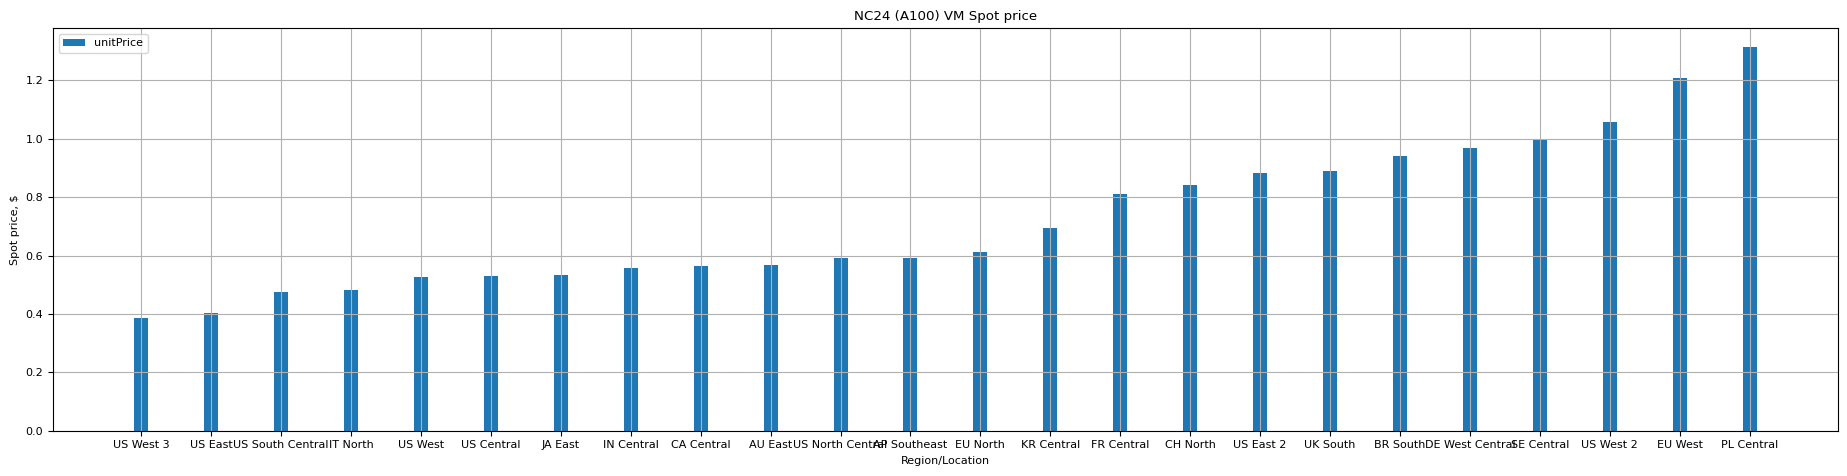

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values('unitPrice')

x_labels = [f"{location}" for location in df["location"]]

x = range(len(df))
width = 0.2

font = {"family": "normal", "size": 8}
plt.rc("font", size=8)

plt.bar(x, df["unitPrice"], width, label="unitPrice")
# plt.bar(x, df["retailPrice"], width, label="Avg")
# plt.bar([i + width for i in x], df["retailPrice"], width, label='p(90)')
# plt.bar([i + 2 * width for i in x], unique_groups_with_best_latency['Latency (ms/token) p(95)'], width, label='p(95)')

plt.xlabel("Region/Location")
plt.ylabel("Spot price, $")
plt.title(f"NC24 (A100) VM Spot price")
plt.xticks([i  for i in x], x_labels)
plt.legend()
plt.grid(True)
plt.tight_layout(rect=[0.1, 0, 3, 1])
plt.show()